In [41]:
import pandas as pd
import numpy as np
from datetime import datetime
from pyproj import Proj, transform
from ipywidgets import HTML
from ipyleaflet import Map, Heatmap, Marker, MarkerCluster, basemaps, LayerGroup, CircleMarker, Polygon, Popup
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.patches as patches
import matplotlib.path as path
from pandarallel import pandarallel
import warnings

from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

pd.options.display.html.table_schema = True
pd.options.display.max_columns = None
style.use('seaborn-darkgrid')
warnings.simplefilter(action='ignore', category=FutureWarning)

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Prepare Data
Clean, transform and merge original data files into a single data file containing the information we need. 

__DO NOT EXECUTE. FILE IS ALREADY IN /DATA/__

In [2]:
# # Read datasets
# df_fincas = pd.read_csv("./data/barcelona/CategoriaCAT_11_fincas.csv", low_memory=False)
# df_unidad_constructiva = pd.read_csv("./data/barcelona/CategoriaCAT_13_unidad_constructiva.csv", low_memory=False)
# df_construcciones = pd.read_csv("./data/barcelona/CategoriaCAT_14_construcciones.csv", low_memory=False)
# df_inmuebles = pd.read_csv("./data/barcelona/CategoriaCAT_15_inmuebles.csv", low_memory=False) #42000 entries


# # # Drop non-required columns
# df_fincas.drop(['codigo_delegacion_meh',  'distrito_municipal', 'codigo_municipio_dgc', 'nombre_provincia', 'nombre_municipio', 'codigo_postal', 'codigo_zona_concentracion', 'codigo_provincia_ine', 'codigo_municipio_dgc_2', 'codigo_municipio_ine', 'nombre_entidad_menor', 'codigo_via_publica_dgc', 'tipo_via', 'primer_numero_policia', 'primera_letra', 'segundo_numero_policia', 'segunda_letra', 'kilometro_por_cien', 'bloque', 'direccion_no_estructurada', 'codigo_municipio_origen_caso_agregacion_dgc', 'codigo_poligono', 'codigo_parcela', 'codigo_paraje_dgc', 'nombre_paraje', 'referencia_catastral_bice', 'denominacion_bice'], axis=1, inplace=True)
# df_construcciones.drop(['codigo_delegacion_meh', 'codigo_municipio_dgc', 'numero_orden_elemento_construccion', 'codigo_unidad_constructiva_asociada', 'bloque', 'escalera', 'puerta', 'tipo_reforma_o_rehabilitacion', 'indicador_local_interior', 'superficie_porches_y_terrazas_m2', 'superficie_imputable_en_otras_plantas_m2', 'tipologia_constructiva', 'modalidad_reparto_elementos_comunes'],axis=1, inplace=True)
# df_inmuebles.drop(['codigo_delegacion_meh', 'superficie_asociada_m2', 'nombre_provincia', 'nombre_municipio', 'codigo_zona_concentracion', 'codigo_provincia_ine', 'codigo_municipio_dgc', 'codigo_municipio_dgc_2', 'codigo_municipio_ine', 'clase_bien_inmueble', 'numero_secuencia_en_parcela', 'primer_caracter_control', 'segundo_caracter_control', 'identificacion_inmueble_segun_ayuntamiento', 'numero_finca_registral', 'nombre_entidad_menor', 'codigo_via_publica_dgc', 'tipo_via', 'nombre_via', 'primer_numero_policia', 'segundo_numero_policia', 'primera_letra', 'segunda_letra', 'kilometro_por_cien', 'bloque', 'escalera', 'planta', 'puerta', 'direccion_no_estructurada', 'codigo_municipio_origen_caso_agregacion_dgc', 'codigo_poligono', 'codigo_parcela', 'codigo_paraje_dgc', 'nombre_paraje', 'numero_orden_inmueble_en_escritura', 'coeficiente_propiedad_en_cienmillonesimas_partes'], axis=1, inplace=True)

# df_fincas.set_index('parcela_catastral', inplace=True)


# # We need to extract the districts from the inmuebles dataset and inject it into the fincas
# df_parcelas_distritos = df_inmuebles[['parcela_catastral', 'distrito_municipal', 'clave_uso']]
# df_parcelas_distritos.set_index('parcela_catastral', inplace=True)
# df_parcelas_distritos = df_parcelas_distritos.loc[~df_parcelas_distritos.index.duplicated(keep='first')]
# df_fincas['distrito_municipal'] = df_parcelas_distritos['distrito_municipal']

# # We extract año de construccion and inject it into fincas
# df_parcelas_ano_construccion = df_unidad_constructiva[['parcela_catastral', 'anyo_construccion']]
# df_parcelas_ano_construccion.set_index('parcela_catastral', inplace=True)
# df_parcelas_ano_construccion = df_parcelas_ano_construccion.loc[~df_parcelas_ano_construccion.index.duplicated(keep='first')]
# df_fincas['anyo_construccion'] = df_parcelas_ano_construccion['anyo_construccion']

# # Merge datadrames on parcela_catastral
# # Fincas is needed for parcela_catastral, coordinates, street name, etc
# # Construcciones is needed for home sizes
# df = pd.DataFrame(df_construcciones.merge(df_fincas, on='parcela_catastral'))
# df = df[ (df['anyo_construccion']>1900) & (df['distrito_municipal']!=0)]

# # Our dataset contains location details about the properties in the EPSG 25830 projection. 
# # To better work with maps, we need to transform them to GPS coordinates (WGS 84 or EPSG 4326) 
# def transform_projections(df_orig):
#     inProj = Proj('epsg:25831')
#     outProj = Proj('epsg:4326')
#     df_sample = df_orig.copy()
#     pandarallel.initialize(progress_bar=True)
    
#     df_loc_temp = df_sample.parallel_apply(lambda row: transform(inProj,outProj,row['coordenada_x_por_cien']/100,row['coordenada_y_por_cien']/100), axis=1)
#     df_sample[['longitud', 'latitud']] = pd.DataFrame(df_loc_temp.values.tolist(), index=df_sample.index, columns=['longitud', 'latitud'])
#     return df_sample

# df = transform_projections(df)

# df.to_csv('data/barcelona/catastro_barcelona_clean.csv')




INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Read data from file
Read the data file and remove outliers 

In [45]:
df = pd.read_csv("./data/barcelona/catastro_barcelona_clean_save.csv")
df = df[ (df['anyo_construccion']>1900) & (df['distrito_municipal']!=0)]

df = df[np.abs(df.superficie_total_efectos_catastro_m2-df.superficie_total_efectos_catastro_m2.mean())<=(3*df.superficie_total_efectos_catastro_m2.std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

df_v = df[ (df['codigo_destino_dgc']=='V') & (df['superficie_total_efectos_catastro_m2']>=20)]

# Building types

In [46]:
trans_codigo_destino_dgc = {
    'V' : 'Vivienda',
    'A' : 'Almacen/Estacionamiento',
    'I' : 'Industrial',
    'O' : 'Oficinas',
    'C' : 'Comercial', 
    'K' : 'Deportivo',
    'T' : 'Espectáculos', 
    'G' : 'Ocio y hostelería',
    'Y' : 'Sanidad y beneficiencia', 
    'E' : 'Cultural', 
    'R' : 'Religioso', 
    'M' : 'Obras, sin edificar', 
    'P' : 'Edificio singular',
    'B' : 'Almacen agrario', 
    'J' : 'Industrial agrario', 
    'Z' : 'Agrario'
}
total_entries = df.count()['parcela_catastral']
types = df.groupby(df.codigo_destino_dgc.str[0]).count()[['superficie_total_efectos_catastro_m2']].rename(columns={'superficie_total_efectos_catastro_m2':'Total inmuebles'})
types[['Tamaño mediano (m2)']] = df.groupby(df.codigo_destino_dgc.str[0]).median().astype(int)[['superficie_total_efectos_catastro_m2']]
types['Año de más construcción'] = df.groupby(df.codigo_destino_dgc.str[0])['anyo_construccion'].agg(pd.Series.mode)

types.rename(trans_codigo_destino_dgc, axis='index', inplace=True)
types.sort_values('Total inmuebles', ascending=False)

,Total inmuebles,Tamaño mediano (m2),Año de más construcción
codigo_destino_dgc,,,
Vivienda,767422,73,1970
Almacen/Estacionamiento,431276,20,1975
Comercial,78428,59,1970
Oficinas,30345,100,1975
Ocio y hostelería,14109,78,1936
Cultural,6406,188,1936
Industrial,5731,186,1970
Sanidad y beneficiencia,5285,138,1975
Deportivo,2870,62,1968


# Barcelona over time
We'll group our dataset by 5-year periods and plot when most homes were built, as well as their average size overtime. 


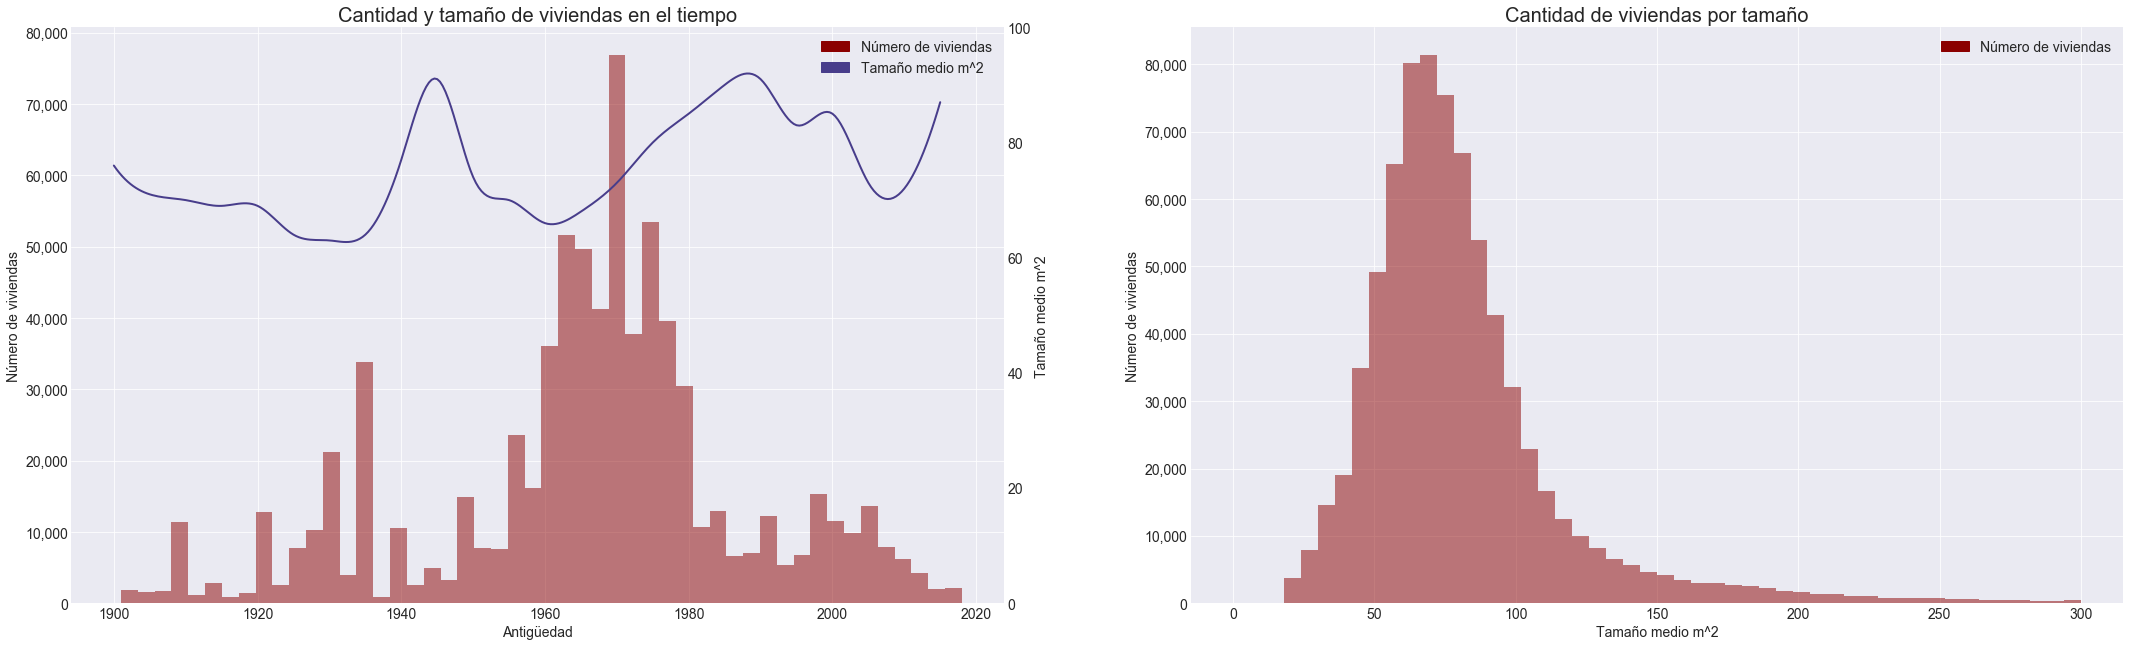

In [47]:
df_cat_by_year = df_v.groupby((df_v.anyo_construccion//5)*5).median()[['superficie_total_efectos_catastro_m2']]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# First graph. Evolution of amount and sizes of homes in the last 100 years
axs[0].hist(df_v['anyo_construccion'], bins=50, color='darkred', alpha=0.5)
ax02 = axs[0].twinx() # Line serie. Size.

xnew = np.linspace(df_cat_by_year.index.min(), df_cat_by_year.index.max(), 300) # Smooth lines
spl = make_interp_spline(df_cat_by_year.index, df_cat_by_year['superficie_total_efectos_catastro_m2'], k=3)
power_smooth = spl(xnew)
ax02.plot(xnew, power_smooth, color='darkslateblue', linewidth=2)
ax02.set_ylim(0,100)
ax02.grid(False)


# Second chart. Amount of homes per size
axs[1].hist(df_v['superficie_total_efectos_catastro_m2'], range=(0, 300), bins=50, color='darkred', alpha=0.5)
plt.subplots_adjust(left=0.1, right=2, top=0.9, bottom=0.1)

# Titles, patches, etc
axs[0].title.set_text('Cantidad y tamaño de viviendas en el tiempo')
axs[0].set_xlabel('Antigüedad')
axs[0].set_ylabel('Número de viviendas')

ax02.set_ylabel('Tamaño medio m^2')

axs[1].title.set_text('Cantidad de viviendas por tamaño')
axs[1].set_xlabel('Tamaño medio m^2')
axs[1].set_ylabel('Número de viviendas')

axs[0].ticklabel_format(axis='y', style='plain', useLocale=True)

red_patch = patches.Patch(color='darkred', label='Número de viviendas')
blue_patch = patches.Patch(color='darkslateblue', label='Tamaño medio m^2')
axs[0].legend(handles=[red_patch, blue_patch])
axs[1].legend(handles=[red_patch])

axs[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()



# Districts analysis
Detect district borders, assign names, see evolution, etc

In [48]:
def get_district_color(district):
    colors = {
        0: "#a0e85b", 
        1: "#1c5b5a", 
        2: "#a2e0dd", 
        3: "#3d4e92", 
        4: "#ca94fd", 
        5: "#0b29d0", 
        6: "#21f0b6", 
        7: "#9f0b64", 
        8: "#32a190", 
        9: "#a6b6f9", 
        10: "#dc58ea"
    }
    return colors[district]

def get_district_name(district):
    district_names = {
        0: "None", 
        1: "Ciutat Vella", 
        2: "Eixample", 
        3: "Sants-Montjuïc", 
        4: "Les Corts", 
        5: "Sarrà-Sant Gervasi", 
        6: "Gràcia", 
        7: "Horta-Guinardó", 
        8: "Nou Barris", 
        9: "Sant Andreu", 
        10: "Sant Martí"    
    }
    return district_names[district]

In [49]:
df_districts_by_year = pd.DataFrame(df_v.groupby([(df_v.anyo_construccion//5)*5, 'distrito_municipal']).count()['parcela_catastral'])
df_districts_by_year = df_districts_by_year.unstack(level=1)['parcela_catastral'].fillna(0)
df_districts_by_year



distrito_municipal,1,2,3,4,5,6,7,8,9,10
anyo_construccion,,,,,,,,,,
1900.0,175,1048,503,3,29,260,21,2,38,184
1905.0,250,1440,499,7,232,571,46,10,69,348
1910.0,2095,4858,1855,120,510,1533,179,25,320,1529
1915.0,266,1422,648,140,384,680,185,20,113,296
1920.0,945,5536,2222,389,1124,1989,555,120,506,1896
1925.0,781,6498,3377,432,1226,1555,948,728,699,1733
1930.0,1404,9492,4686,616,2079,3911,871,145,907,2964
1935.0,5457,8065,5672,714,3402,4656,1791,468,1250,2960
1940.0,1030,3801,733,275,2641,1617,890,166,984,1094


Text(0.5,0.98,'Nuevas viviendas por distritos en el tiempo')

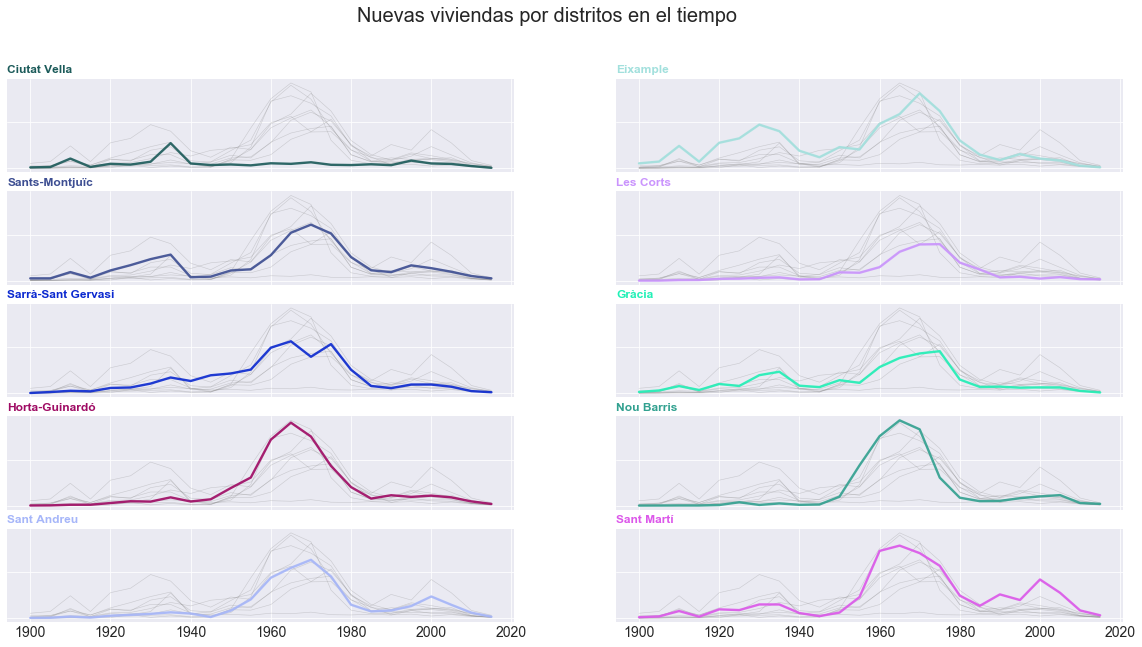

In [50]:
plt.figure(figsize=(20,10))

# multiple line plot
num=0
for district in df_districts_by_year.columns:
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(5,2, num)
 
    # plot every groups, but discreet
    for district_2 in df_districts_by_year.columns:
        plt.plot(df_districts_by_year.index, df_districts_by_year[district_2], marker='', color='gray', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.plot(df_districts_by_year.index, df_districts_by_year[district], marker='', color=get_district_color(district), linewidth=2.4, alpha=0.9, label='hola')
 
    # Same limits for everybody!
    #plt.xlim(0,10)
    #plt.ylim(-2,22)
 
    # Not ticks everywhere
    if num in range(9) :
        plt.tick_params(labelbottom=False)
    
    # No ticks on the y axis
    plt.tick_params(labelleft=False)
 
    # Add title
    plt.title(get_district_name(district), loc='left', fontsize=12, fontweight='bold', color=get_district_color(district))
    #plt.yscale('log')


plt.suptitle("Nuevas viviendas por distritos en el tiempo")

# Districts identification
Data contains "districts", which are defined by numbers from 1 to N and are specific to each city. We have no idea what these districts are or where they are located, but we know to which district each property belongs. By selecting all properties for each district and making a Convex Hull over their coordinates, we can get a good idea of the area each distric covers. 

In [51]:
center = (41.410917, 2.192996)
m = Map(center = center, zoom = 12, min_zoom = 1, max_zoom = 20, 
    basemap=basemaps.CartoDB.Positron)

df_sample = df_v.sample(1000)

# Draw markers
markers = []
for index, row in df_sample.iterrows():
    circle_marker = CircleMarker()
    circle_marker.location = (row['longitud'], row['latitud'])
    circle_marker.radius = 1
    circle_marker.color = get_district_color(row['distrito_municipal'])
    markers.append(circle_marker)

    
# Draw polygons / clusters
polygons, popups = [], []
for val in df_sample['distrito_municipal'].unique():
    coords = ()
    l = df_sample[df_sample['distrito_municipal']==val][['longitud', 'latitud']].values.tolist()
    # Detect borders by creating a Convex Hull
    hull = ConvexHull(l)
    vertices = [l[i] for i in list(hull.vertices)]
    polygon = Polygon(
        locations=vertices,
        color=get_district_color(val),
        fill_color=get_district_color(val)
    )
    polygons.append(polygon)
    
    # Get centoid of the hull to position the label. Not working at the moment... for some reason
    #     cx = np.mean(hull.points[hull.vertices,0])
    #     cy = np.mean(hull.points[hull.vertices,1])

    #     message1 = HTML()
    #     message1.value = "District "+str(val)

    #     popup = Popup(
    #         location=(cx, cy),
    #         child=message1,
    #         close_button=False,
    #         auto_close=False,
    #         close_on_escape_key=False
    #     )
    #     popups.append(popup)
    
layer_group_markers = LayerGroup(layers=(markers))
layer_group_polygons = LayerGroup(layers=(polygons))
layer_group_popups = LayerGroup(layers=(popups))

m.add_layer(layer_group_markers)
m.add_layer(layer_group_polygons)
m.add_layer(layer_group_popups)

m

Map(center=[41.410917, 2.192996], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

# Streets
Identify main streets by number of houses as well as higher sizes

In [54]:
df_streets = pd.DataFrame(df_v.groupby(df_v.nombre_via).mean().astype(int)['superficie_total_efectos_catastro_m2'])
df_streets['Tamaño mediano m2'] = df_v.groupby(['nombre_via']).median().astype(int)['superficie_total_efectos_catastro_m2']
df_streets['Desviación típica'] = df_v.groupby(['nombre_via']).std()['superficie_total_efectos_catastro_m2']
df_streets['Total viviendas'] = df_v.groupby(['nombre_via']).count()['superficie_total_efectos_catastro_m2']
df_streets.rename(columns={'superficie_total_efectos_catastro_m2': 'Tamaño medio m2'}, inplace=True)

data_top_total = df_streets.sort_values('Total viviendas', ascending=False).head(10)
data_top_m2 = df_streets[df_streets['Total viviendas']>200].sort_values('Tamaño medio m2', ascending=False).head(10)

#data_top_total.head(10)
data_top_m2.head(10)

,Tamaño medio m2,Tamaño mediano m2,Desviación típica,Total viviendas
nombre_via,,,,
REINA VICTORIA,244,247,105.930926,297
FERRAN AGULLO,221,226,128.579289,241
PAU CASALS,217,174,123.897193,227
EMANCIPACIO,196,197,98.810217,258
CAVALLERS,192,179,103.980915,299
BORI I FONTESTA,191,184,87.277730,380
RASET,186,145,119.849536,230
ESCOLES PIES,183,172,98.547519,618
DOCTOR ROUX,179,173,86.077374,387


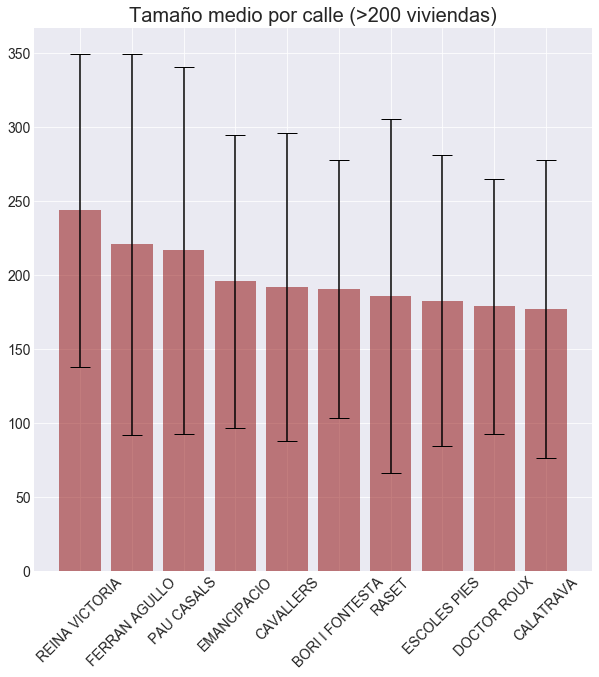

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

std_m2 = data_top_m2['Desviación típica']

ax.bar(data_top_m2.index, data_top_m2['Tamaño medio m2'], color='darkred', alpha=0.5, yerr=std_m2, ecolor='black', capsize=10)
plt.title("Tamaño medio por calle (>200 viviendas)")
plt.xticks(rotation=45)
plt.show()
#data_top_total

In [56]:

center = (41.410917, 2.192996)
m = Map(center = center, zoom = 13, 
    basemap=basemaps.CartoDB.Positron)

# Normalize size column
sizes = df_v[['superficie_total_efectos_catastro_m2']].values.astype(float)
min_max_scaler = MinMaxScaler()
sizes_scaled = min_max_scaler.fit_transform(sizes)

pd.set_option('mode.chained_assignment', None)
df_v.loc[:, 'superficie_total_efectos_catastro_m2_scaled'] = sizes_scaled
heatmap = Heatmap(
    locations=df_v.sample(300000)[['longitud', 'latitud', 'superficie_total_efectos_catastro_m2_scaled']].values.tolist(),
    radius=11,
    gradient = {0.3: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.80: 'orange', 1: 'red'}
)

m.add_layer(heatmap);
m.layout.width = '100%'
m.layout.height = '700px'
m

Map(center=[41.410917, 2.192996], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …